#### a feature:
- the league position of the teams in the previous season
- maybe a current league position of bothe teams at the moment when the match is happening

#### outlier removals to be done
#### more algorithms and more corresponding search spaces


In [2]:
import warnings
%load_ext autoreload
%autoreload 2
warnings.simplefilter('ignore')

# "chr=conceded-home-rolling"
# "car=conceded-away-rolling"
# "hr=home-rolling"    
# "ar=away-rolling"

In [40]:
from preprocess import pack
import optimization
from features import Features, features_targets
import utils

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from collections import OrderedDict
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score

In [22]:
pack['data'].columns,pack['home_data'].columns

(Index(['season', 'datetime', 'ftr', 'htr', 'referee', 'hometeam', 'fthg',
        'hthg', 'hs', 'hst', 'hc', 'hf', 'hy', 'hr', 'hp', 'hhp', 'awayteam',
        'ftag', 'htag', 'as', 'ast', 'ac', 'af', 'ay', 'ar', 'ap', 'hap'],
       dtype='object'),
 Index(['season', 'datetime', 'ftr', 'htr', 'referee', 'hometeam', 'fthg',
        'hthg', 'hs', 'hst', 'hc', 'hf', 'hy', 'hr', 'hp', 'hhp'],
       dtype='object'))

In [23]:
feat = Features(**pack)
data = feat.execute()
container = features_targets(data)
features = container.trainx
target = container.trainy

trainx,valx,trainy,valy=train_test_split(features,target)
trainx.reset_index(inplace=True,drop=True)
valx.reset_index(inplace=True,drop=True)
trainy.reset_index(inplace=True,drop=True)
valy.reset_index(inplace=True,drop=True)

In [28]:
best_params = optimization.optimizer(features,target, 'XGBoost_classif')

XGBoost_classif took 3925.00 seconds,  candidates checked: 120, best CV score: 0.597 ± 0.001
Best parameters:
OrderedDict([('booster', 'gbtree'),
             ('colsample_bytree', 0.6302194630442275),
             ('learning_rate', 0.01),
             ('max_depth', 1),
             ('max_leaves', 49),
             ('n_estimators', 500),
             ('reg_lambda', 1e-09),
             ('sampling_method', 'uniform'),
             ('subsample', 0.6912252213398504)])


In [11]:
model = XGBClassifier(random_state=0, tree_method='hist',objective='multi:softprob',
                      eval_metric=accuracy_score, verbosity=0, num_class=3, **best_params)
model.fit(trainx,trainy)
t_preds=model.predict(trainx)
v_preds=model.predict(valx)

In [12]:
# import features
# best = features.auto_best_features(trainx, trainy, n_features=30)

In [46]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(v_preds,valy))
print(f1_score(v_preds,valy,average='weighted'))
print(recall_score(v_preds,valy,average='weighted'))
print(precision_score(v_preds,valy,average='weighted'))
accuracy_score(v_preds,valy)

[[  0   0   0]
 [178 400 119]
 [327 208 841]]
0.6840553867700249
0.5986493005306319
0.8026946285153309


0.5986493005306319

In [48]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(t_preds,trainy))
print(f1_score(t_preds,trainy,average='weighted'))
print(recall_score(t_preds,trainy,average='weighted'))
print(precision_score(t_preds,trainy,average='weighted'))
accuracy_score(t_preds,trainy)

[[   2    1    0]
 [ 716 1629  499]
 [1351  787 3304]]
0.6817433311845511
0.5953673543250091
0.8016327489564088


0.5953673543250091

In [81]:
out_index=iqr(data,data.select_dtypes('number').columns)
out_index.shape[0]/data.shape[0]

0.5074194715888527

In [60]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


In [87]:
data=pack['data'].select_dtypes('number')
iforest = IsolationForest(n_estimators=100, max_samples='auto',
                          contamination=0.5, max_features=1.0,
                          bootstrap=False, n_jobs=-1, random_state=1)
index,values=utils.isolation_forest(pack['data'].select_dtypes('number'),iforest)
data.drop(index[0], axis=0)

(4144,)

In [76]:
lof = LocalOutlierFactor(n_neighbors=20, algorithm='auto',
                         metric='minkowski', contamination=0.02,
                         novelty=False, n_jobs=-1)
index,values=utils.lof(trainx,lof)
index[0].shape

(125,)

In [77]:
ex=pack['data'].select_dtypes('number')
index=iqr(ex,['fthg'])
print(index.shape)

ex[['fthg','hs']]
index,values=utils.lof(ex[['fthg','hs']],lof)

(625,)


<AxesSubplot:xlabel='fthg', ylabel='hs'>

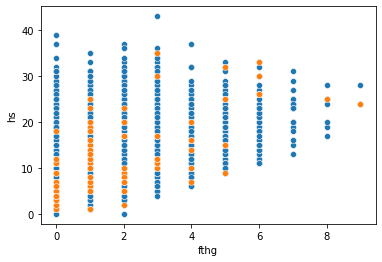

In [84]:

sns.scatterplot(pack['data']['fthg'],pack['data']['hs'])
sns.scatterplot(pack['data']['fthg'].iloc[index[0]],pack['data']['hs'].iloc[index[0]])

,fthg,hthg,hs,hst,hc,hf,hy,hr,hp,hhp,ftag,htag,as,ast,ac,af,ay,ar,ap,hap
0,4,2.0,17.0,14.0,6.0,13.0,1.0,0.0,3,3,0,0.0,8.0,4.0,6.0,12.0,2.0,0.0,0,0
1,4,1.0,17.0,10.0,7.0,19.0,1.0,0.0,3,3,2,0.0,12.0,5.0,7.0,14.0,2.0,0.0,0,0
4,2,2.0,17.0,8.0,6.0,21.0,1.0,0.0,3,3,0,0.0,12.0,6.0,4.0,20.0,3.0,0.0,0,0
5,0,0.0,5.0,4.0,5.0,12.0,2.0,0.0,1,1,0,0.0,5.0,3.0,4.0,12.0,3.0,0.0,1,1
6,1,0.0,16.0,10.0,6.0,8.0,1.0,0.0,3,1,0,0.0,3.0,2.0,1.0,8.0,1.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8279,1,0.0,12.0,4.0,1.0,6.0,1.0,0.0,3,1,0,0.0,5.0,2.0,2.0,13.0,1.0,0.0,0,1
8282,1,1.0,7.0,3.0,5.0,4.0,2.0,0.0,3,3,0,0.0,12.0,4.0,7.0,10.0,2.0,0.0,0,0
8285,2,0.0,15.0,7.0,4.0,2.0,0.0,0.0,3,1,0,0.0,5.0,1.0,6.0,6.0,1.0,0.0,0,1
8286,2,2.0,12.0,3.0,3.0,11.0,1.0,0.0,3,3,1,0.0,11.0,3.0,4.0,12.0,1.0,0.0,0,0
